In [42]:
%matplotlib inline

# General libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from collections import defaultdict

# SK-learn libraries for learning.
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit


In [2]:
# loading datasets
sample_df = pd.read_csv("./forest-cover-type-prediction/sampleSubmission.csv")
train_df = pd.read_csv("./forest-cover-type-prediction/train.csv")
test_df = pd.read_csv("./forest-cover-type-prediction/test.csv")

In [27]:
# Conduct quick sanity check imported data
# Sample submission is just sample file for submission instructions, can ignore
# Test_df is used for predictions
display(train_df.head())
print("Training data shape:",train_df.shape)
print(train_df.dtypes)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


Training data shape: (15120, 56)
Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64

In [10]:
print("Test data shape:",test_df.shape)
print(test_df.columns)
# Test_df does not have cover_type column
# Will need to subset train_df to train and dev datasets

Test data shape: (565892, 55)
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_

In [29]:
pd.set_option('display.max_columns', None)
print(train_df.describe())

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

> **Results**: 
   - (1) no missing data for all variables;
   - (2) All values for Soil_Type7 and Soil_Type15 are zero --> meaningless for cover_type prediction

In [31]:
# Count the number of instances of each class
print(train_df.groupby('Cover_Type').size())

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


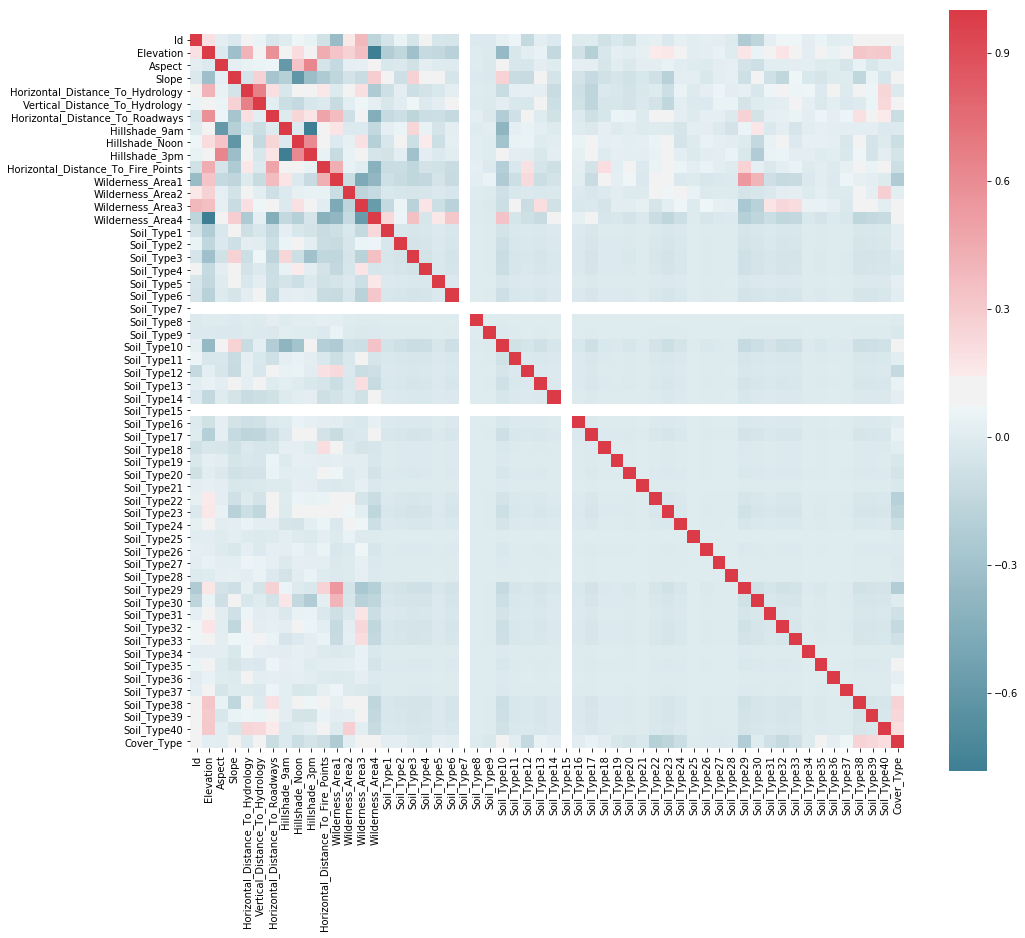

In [19]:
# Plot correlation heatmap to find highly correlated variables /features
corr = train_df.corr()

f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


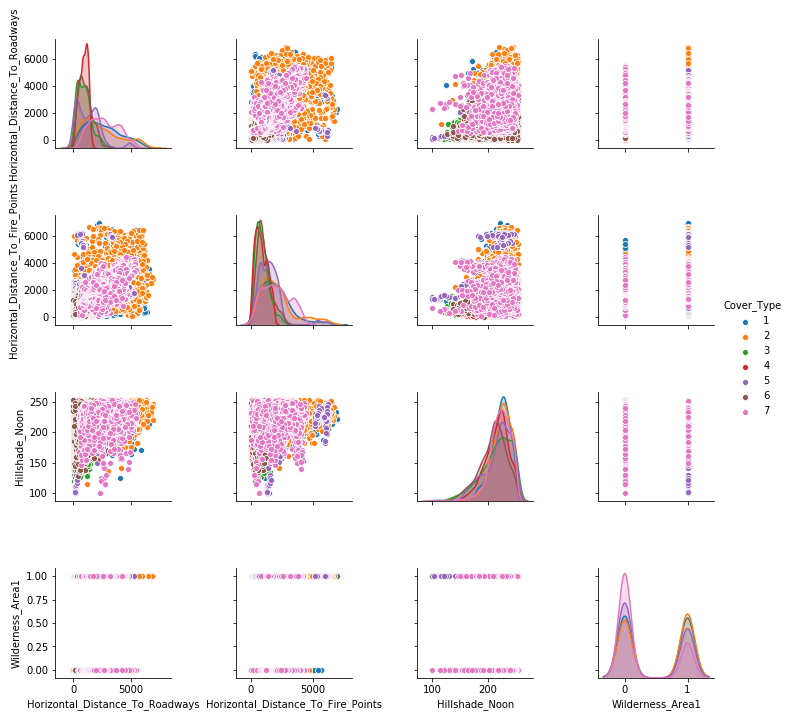

In [25]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Horizontal_Distance_To_Roadways",
                                               "Horizontal_Distance_To_Fire_Points", 
                                               "Hillshade_Noon","Wilderness_Area1"])

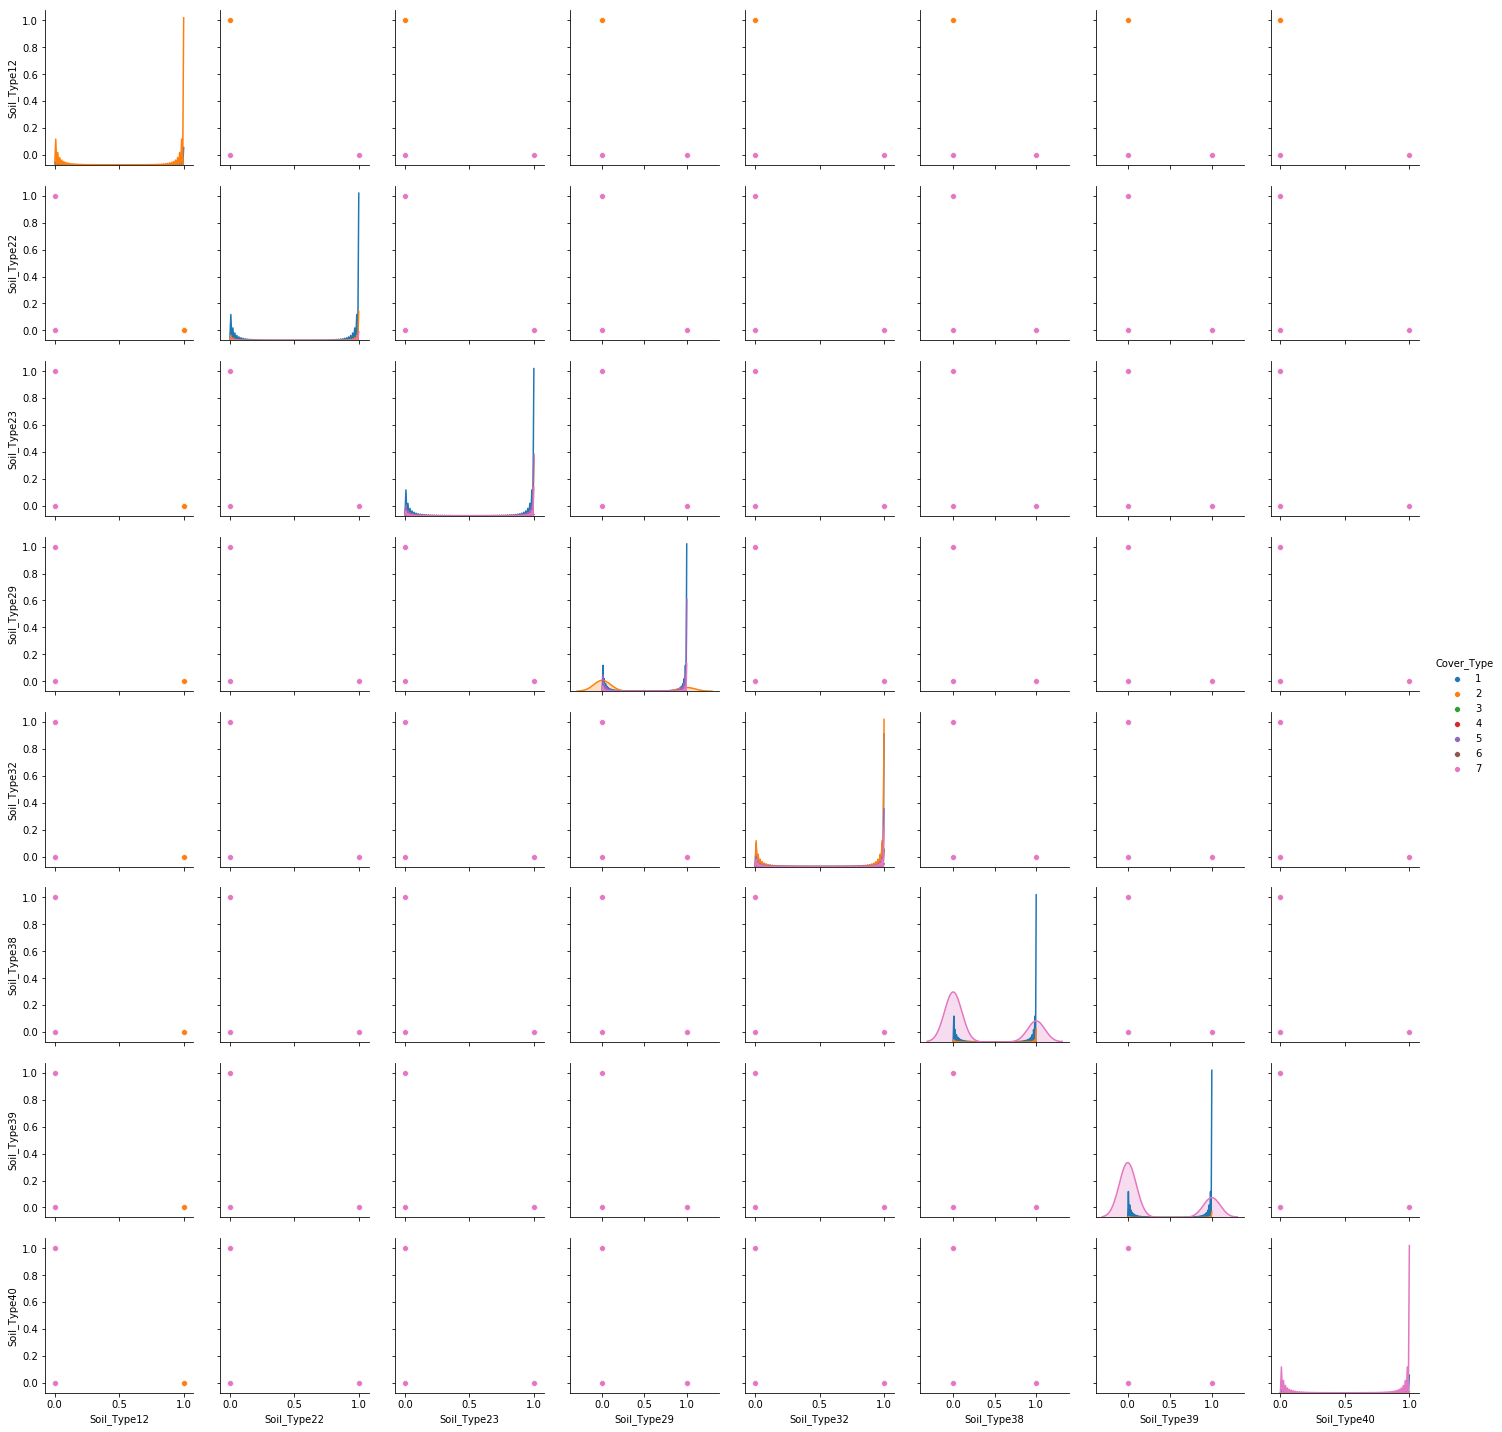

In [24]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Soil_Type12","Soil_Type22",
                                               "Soil_Type23","Soil_Type29",
                                               "Soil_Type32","Soil_Type38",
                                               "Soil_Type39","Soil_Type40"])

In [56]:
# Convert pd dataframe to np array
# Split train_df into training data and dev data <= This should be done at the top
forest_data = train_df.loc[:,:"Soil_Type40"].values
forest_target = train_df[['Cover_Type']].values.flatten()

print(forest_data.shape)
print(type(forest_data))
print(forest_target.shape)
print(type(forest_target))
print(forest_target[:3])


(15120, 55)
<class 'numpy.ndarray'>
(15120,)
<class 'numpy.ndarray'>
[5 5 2]


In [62]:
X_train, X_dev, y_train, y_dev = train_test_split(forest_data, forest_target, test_size=0.3, random_state=0)
print("Training data shape:", X_train.shape)
print("Training label shape:", y_train.shape)
print("Dev data shape:", X_dev.shape)
print("Dev label shape:", y_dev.shape)

Training data shape: (10584, 55)
Training label shape: (10584,)
Dev data shape: (4536, 55)
Dev label shape: (4536,)


In [60]:
names = train_df.columns.values
print(type(names))
print(names)

<class 'numpy.ndarray'>
['Id' 'Elevation' 'Aspect' 'Slope' 'Horizontal_Distance_To_Hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'Wilderness_Area1'
 'Wilderness_Area2' 'Wilderness_Area3' 'Wilderness_Area4' 'Soil_Type1'
 'Soil_Type2' 'Soil_Type3' 'Soil_Type4' 'Soil_Type5' 'Soil_Type6'
 'Soil_Type7' 'Soil_Type8' 'Soil_Type9' 'Soil_Type10' 'Soil_Type11'
 'Soil_Type12' 'Soil_Type13' 'Soil_Type14' 'Soil_Type15' 'Soil_Type16'
 'Soil_Type17' 'Soil_Type18' 'Soil_Type19' 'Soil_Type20' 'Soil_Type21'
 'Soil_Type22' 'Soil_Type23' 'Soil_Type24' 'Soil_Type25' 'Soil_Type26'
 'Soil_Type27' 'Soil_Type28' 'Soil_Type29' 'Soil_Type30' 'Soil_Type31'
 'Soil_Type32' 'Soil_Type33' 'Soil_Type34' 'Soil_Type35' 'Soil_Type36'
 'Soil_Type37' 'Soil_Type38' 'Soil_Type39' 'Soil_Type40' 'Cover_Type']


In [61]:
# Rank feature importance based off Random Forest Regressor results
names = train_df.columns.values
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.3844, 'Elevation'), (0.0987, 'Id'), (0.0657, 'Horizontal_Distance_To_Fire_Points'), (0.0638, 'Horizontal_Distance_To_Roadways'), (0.0476, 'Horizontal_Distance_To_Hydrology'), (0.0421, 'Soil_Type39'), (0.0374, 'Hillshade_3pm'), (0.0351, 'Vertical_Distance_To_Hydrology'), (0.0304, 'Aspect'), (0.0286, 'Soil_Type38'), (0.0285, 'Hillshade_9am'), (0.0265, 'Hillshade_Noon'), (0.021, 'Slope'), (0.0123, 'Wilderness_Area3'), (0.0122, 'Soil_Type32'), (0.0073, 'Soil_Type35'), (0.0066, 'Soil_Type10'), (0.005, 'Soil_Type40'), (0.0048, 'Soil_Type22'), (0.0046, 'Soil_Type29'), (0.0043, 'Soil_Type33'), (0.0036, 'Soil_Type30'), (0.0031, 'Wilderness_Area1'), (0.003, 'Soil_Type24'), (0.0027, 'Soil_Type4'), (0.0026, 'Soil_Type13'), (0.0024, 'Wilderness_Area4'), (0.0019, 'Soil_Type23'), (0.0018, 'Soil_Type20'), (0.0015, 'Soil_Type12'), (0.0012, 'Soil_Type2'), (0.0012, 'Soil_Type11'), (0.0011, 'Soil_Type31'), (0.0011, 'Soil_Type17'), (0.0009, 'Soil_Type6'), (0.0009, 'Soil_

In [45]:
# Add random splits of test/dev data to see if any change in feature importance
rf = RandomForestRegressor()
scores = defaultdict(list)
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
 
# crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in rs.split(forest_data):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(train_df.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print("Features sorted by their score:")
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

TypeError: 'ShuffleSplit' object is not iterable